In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split

In [288]:
virus_labeled_data = pd.read_csv("virus_labeled.csv")
virus_unlabeled_data = pd.read_csv("virus_unlabeled.csv")
pid = virus_unlabeled_data['patient_id']

In [289]:
def preprare_data(data, training_data):
    data_res = data.copy()
    data_res = pd.concat([data_res, pd.get_dummies(data_res['blood_type'], prefix="blood_type")], axis=1)
    cough, fever, headache, low_appetite, shortness_of_breath = [0] * data_res.shape[0], [0] * data_res.shape[0], [0] * data_res.shape[
        0], [0] * data_res.shape[0], [0] * data_res.shape[0]
    for i, row in enumerate(data['symptoms']):
        if row == np.NaN:  # in case that it is None
            continue
        if 'cough' in str(row):
            cough[i] = 1
        if 'fever' in str(row):
            fever[i] = 1
        if 'headache' in str(row):
            headache[i] = 1
        if 'low_appetite' in str(row):
            low_appetite[i] = 1
        if 'shortness_of_breath' in str(row):
            shortness_of_breath[i] = 1
    # we decided to not add other symptoms
    data_res['symptoms_cough'] = cough
    data_res['symptoms_fever'] = fever
    data_res['symptoms_shortness_of_breath'] = shortness_of_breath
    PCR = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_06' , 'PCR_08','PCR_10']

    continuous = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_06','PCR_07','PCR_08', 'PCR_10','household_income', 'sugar_levels','weight']
    categorial = ['num_of_siblings', 'sex']

    #drop unwanted features
    drop_list = ['patient_id', 'age','blood_type_B+','blood_type_A+','blood_type_AB+','blood_type_B-','blood_type_O+','blood_type_O-'
                 ,'blood_type_AB-','blood_type_A-','address','current_location','job','happiness_score','pcr_date',
                 'symptoms','sport_activity','PCR_04','PCR_05','PCR_09','conversations_per_day']
    data_res.drop(columns=drop_list,inplace=True)

    # treat outiers
    for i, column in enumerate(PCR, 1):
        upper_limit = training_data[column].quantile(0.97)
        lower_limit = training_data[column].quantile(0.03)
        data_res.loc[(data[column] > upper_limit), column] = upper_limit
        data_res.loc[(data[column] < lower_limit), column] = lower_limit

    #fill misssing values
    for c in continuous:
        data_res[c].fillna((training_data[c].mean()), inplace=True)
    for c in categorial:
        data_res.fillna(training_data.mode().iloc[0], inplace=True)
    data_res['sex'] = data_res['sex'].replace({'M': 1, 'F': 0})
    #normalize
    for c in continuous:
        data_res[c] = (data_res[c]-data_res[c].min())/(data_res[c].max()-data_res[c].min())
    for c in categorial:
        data_res[c] = (data_res[c]-data_res[c].min())/(data_res[c].max()-data_res[c].min())
    return data_res



In [290]:
virus_labeled_tr, virus_labeled_te = train_test_split(virus_labeled_data, test_size=0.2, random_state=12)

In [291]:
virus_labeled_train = preprare_data(virus_labeled_tr, virus_labeled_tr)
virus_labeled_test = preprare_data(virus_labeled_te, virus_labeled_train)
virus_unlabeled_data = preprare_data(virus_unlabeled_data, virus_unlabeled_data)
virus_labeled_data = preprare_data(virus_labeled_data, virus_labeled_data)

In [292]:
X = virus_labeled_train.drop(["VirusScore"],1)
y = virus_labeled_train['VirusScore']

Section 1

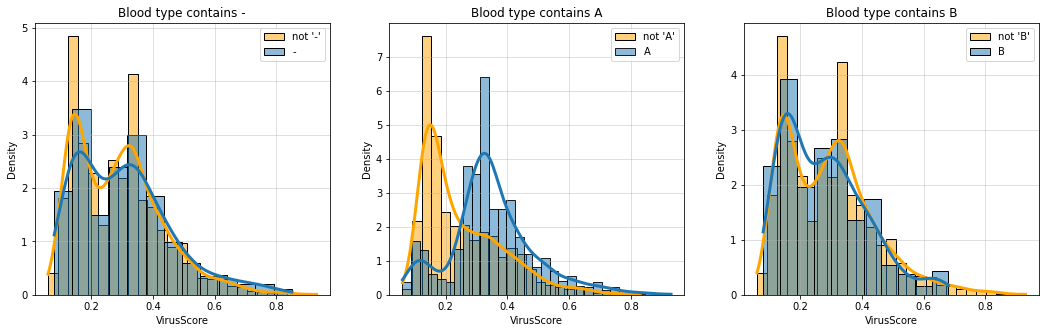

In [293]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, cur_type in enumerate(['-', 'A', 'B']):
  filter_mask = X['blood_type'].str.contains(cur_type)
  sns.histplot(data=y[~filter_mask], ax=ax[i], stat="density", kde=True,
  line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type))
  sns.histplot(data=y[filter_mask], ax=ax[i], stat="density", kde=True,
  line_kws={"linewidth": 3}, label=cur_type)
  ax[i].set_title("Blood type contains " + cur_type)
  ax[i].legend(), ax[i].grid(alpha=0.5)
plt.show()

In [294]:
virus_labeled_train['blood_type_A'] = np.where(virus_labeled_train['blood_type'].str.contains('A'), 1, 0)
virus_labeled_test['blood_type_A'] = np.where(virus_labeled_test['blood_type'].str.contains('A'), 1, 0)
virus_labeled_train= virus_labeled_train.drop(["blood_type"],1)
virus_labeled_test= virus_labeled_test.drop(["blood_type"],1)

Section 2

In [295]:
virus_labeled_train_new, virus_labeled_test_new = train_test_split(virus_labeled_train, test_size=0.2, random_state=12)

In [296]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from numpy import linalg as LA


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        loss = None
        b_vec = np.full(y.shape,b)
        Xw = np.matmul(X,w)
        in_norm1 = Xw + b_vec 
        in_norm = in_norm1 - y
        out_norm = LA.norm (in_norm)
        loss= (1/X.shape[0])*out_norm
        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        g_w = None
        g_b = 0.0
        b_vec = np.full(y.shape,b)
        Xw = np.matmul(X,w)
        Xw_y = Xw - y
        ones = np.ones(y.shape)
        Xw_y_ones = np.dot(Xw_y,ones)
        g_b = (2 * b) + (2 / y.shape[0]) * Xw_y_ones
        Xw_y_b = Xw_y + b_vec
        Xt_norm = np.matmul(X.T,Xw_y_b)
        g_w = (2/X.shape[0]) * Xt_norm
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b ,batch_X,batch_y)
            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b
            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        y_pred = np.dot(self.w.T,X) + self.b
        return y_pred

In [297]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


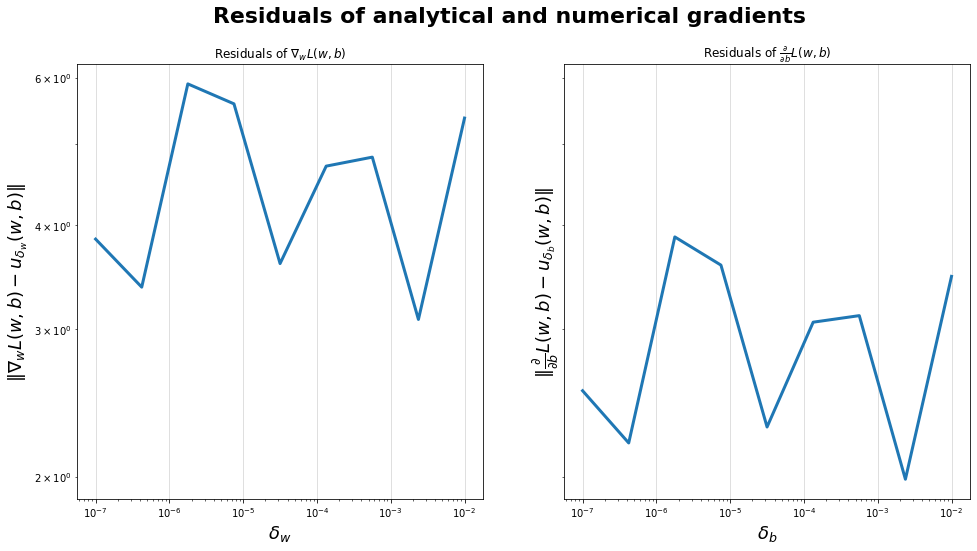

In [298]:
pd.set_option('display.max_columns', 50)
X_new = np.array(virus_labeled_train_new.drop(["VirusScore"],1))
y_new = np.array(virus_labeled_train_new['VirusScore'])
compare_gradients(X_new, y_new, deltas=np.logspace(-7, -2, 9))

In [299]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')


lr size = 1e-09, Best train loss = 0.007416205827550351, Best validation loss = 0.014560072423696283
lr size = 1e-08, Best train loss = 0.007415679365554857, Best validation loss = 0.014559014572977388
lr size = 1e-07, Best train loss = 0.007410417690444654, Best validation loss = 0.01454844204735069
lr size = 1e-06, Best train loss = 0.007358094538668969, Best validation loss = 0.014443313174015546
lr size = 1e-05, Best train loss = 0.006863356176453745, Best validation loss = 0.0134499261834335
lr size = 0.0001, Best train loss = 0.004041816367373742, Best validation loss = 0.007850492222801911
lr size = 0.001, Best train loss = 0.0027318268168630743, Best validation loss = 0.005480101424471895
lr size = 0.01, Best train loss = 0.002060479709821509, Best validation loss = 0.004025666252445323
lr size = 0.1, Best train loss = 0.002001613784489306, Best validation loss = 0.003823140359292701


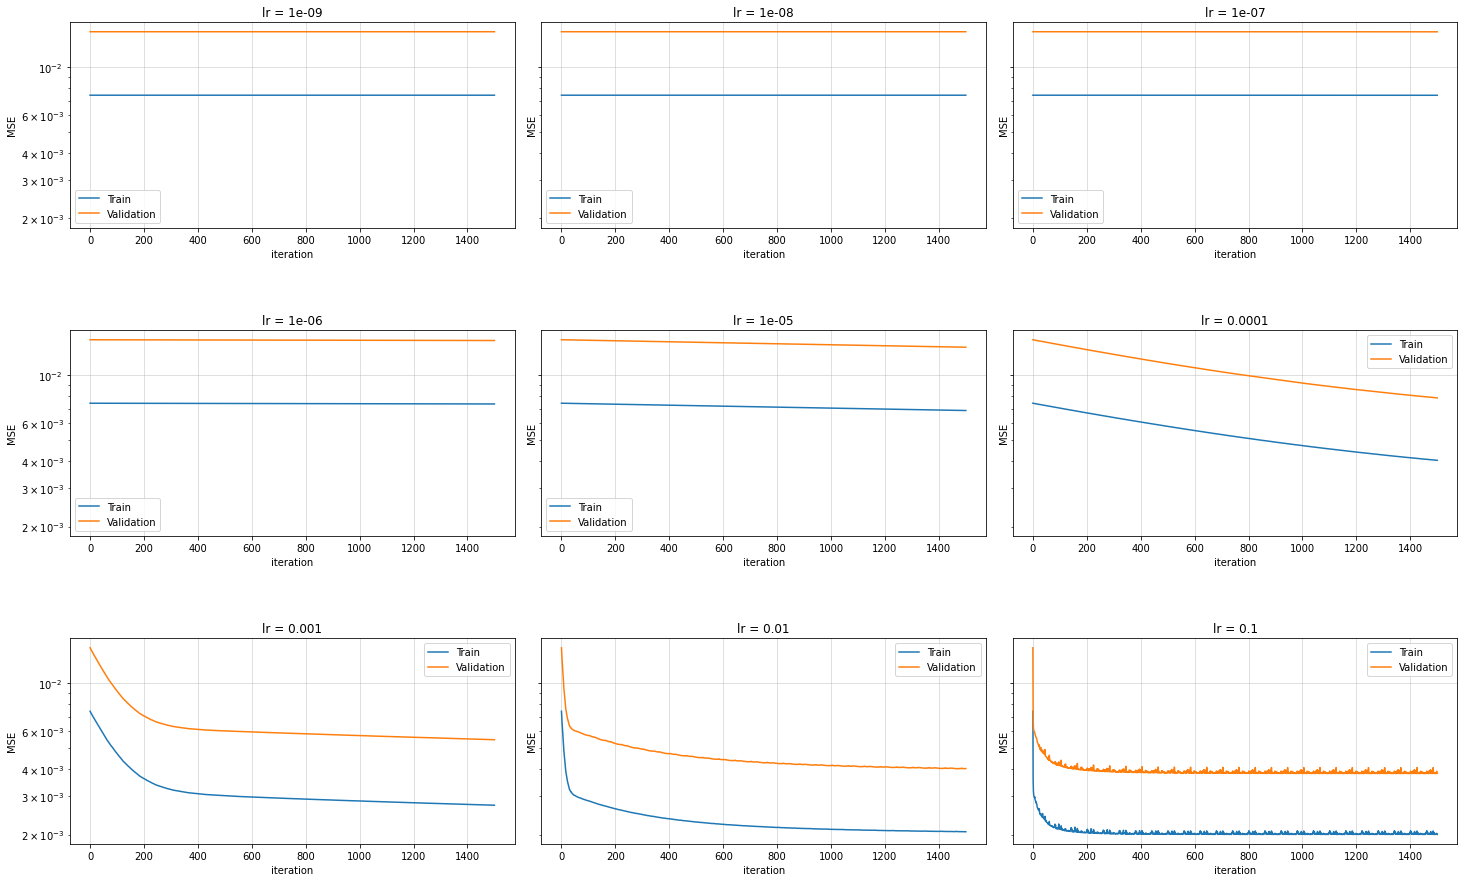

In [300]:
X_val = np.array(virus_labeled_test_new.drop(["VirusScore"],1))
y_val = np.array(virus_labeled_test_new["VirusScore"])
test_lr(X_new, y_new, X_val, y_val)

In [301]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
X = virus_labeled_train.drop(["VirusScore"],1)
y = virus_labeled_train['VirusScore']
dummy_regr = dummy_regr.fit(X, y)

In [302]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(dummy_regr, X, y, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
tr_score = cv_results['train_score']
test_score = cv_results['test_score']
tr_mse = np.mean(np.abs(tr_score))
test_mse = np.mean(np.abs(test_score))
print(tr_mse,test_mse)
dummy_regr = dummy_regr.fit(X, y)

0.020272575509982637 0.020283053049045142


Section 4

4 0.0076498246770981115
0 0.0075355590909086875


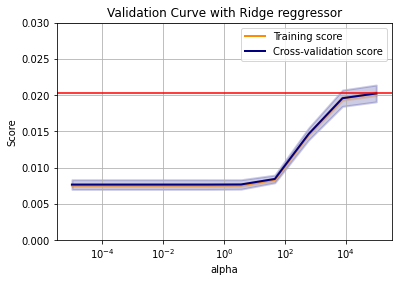

In [303]:
from sklearn.linear_model import Ridge
alpha_range = np.logspace(-5, 5, 10)
ridge = Ridge(alpha=1.0, fit_intercept=True)

train_scores, test_scores  = sklearn.model_selection.validation_curve(ridge,X,y,param_name='alpha',scoring='neg_mean_squared_error',param_range=alpha_range,cv = 5)
train_scores_mean = np.mean(np.abs(train_scores), axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(np.abs(test_scores), axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge reggressor")
plt.xlabel(r"$\k$")
plt.ylabel("Score")
plt.ylim(0, 0.03)
lw = 2
plt.semilogx(
    alpha_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    alpha_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    alpha_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    alpha_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
ymax = min(test_scores_mean)
index = np.argmin(test_scores_mean)
ymax2 = min(train_scores_mean)
index2 = np.argmin(train_scores_mean)
print(index,ymax)
print(index2,ymax2)
plt.axhline(y=test_mse, color='r', linestyle='-')

plt.grid()
plt.xlabel("alpha")
plt.legend(loc="best")
plt.show()

In [304]:
ridge = Ridge(alpha=0.1, fit_intercept=True)
ridge = ridge.fit(X,y)

In [305]:
cof = np.abs(ridge.coef_)
indices = (-cof).argsort()
print(X.columns[indices])

Index(['symptoms_shortness_of_breath', 'num_of_siblings', 'PCR_07',
       'symptoms_fever', 'PCR_08', 'blood_type_A', 'household_income',
       'symptoms_cough', 'PCR_10', 'weight', 'sugar_levels', 'PCR_06', 'sex',
       'PCR_01', 'PCR_03', 'PCR_02'],
      dtype='object')


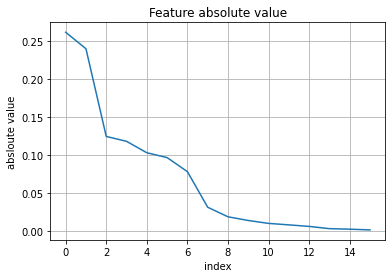

In [306]:
cof = np.abs(ridge.coef_)
cof[::-1].sort()
indexes = range(16)
plt.plot(indexes,cof)
plt.grid()
plt.xlabel("index")
plt.ylabel("absloute value")
plt.title("Feature absolute value")
plt.show()

0 0.007650380152048541
0 0.007535664534436627


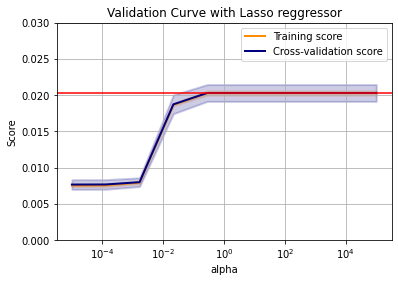

In [307]:
from sklearn.linear_model import Lasso
alpha_range = np.logspace(-5, 5, 10)
lasso = Lasso(alpha=1.0, fit_intercept=True)

train_scores, test_scores  = sklearn.model_selection.validation_curve(lasso,X,y,param_name='alpha',scoring='neg_mean_squared_error',param_range=alpha_range,cv = 5)
train_scores_mean = np.mean(np.abs(train_scores), axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(np.abs(test_scores), axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Lasso reggressor")
plt.xlabel(r"$\k$")
plt.ylabel("Score")
plt.ylim(0, 0.03)
lw = 2
plt.semilogx(
    alpha_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    alpha_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    alpha_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    alpha_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
ymax = min(test_scores_mean)
index = np.argmin(test_scores_mean)
ymax2 = min(train_scores_mean)
index2 = np.argmin(train_scores_mean)
print(index,ymax)
print(index2,ymax2)
plt.axhline(y=test_mse, color='r', linestyle='-')

plt.grid()
plt.xlabel("alpha")
plt.legend(loc="best")
plt.show()

In [308]:
lasso = Lasso(alpha=0.0001, fit_intercept=True)
lasso = lasso.fit(X,y)
cof = np.abs(lasso.coef_)
indices = (-cof).argsort()[:5]
print(X.columns[indices])

Index(['symptoms_shortness_of_breath', 'num_of_siblings', 'symptoms_fever',
       'PCR_08', 'blood_type_A'],
      dtype='object')


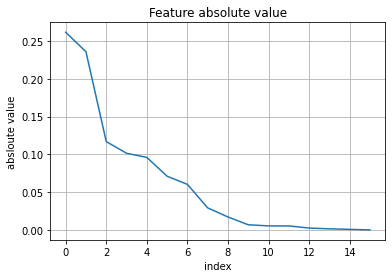

In [309]:
cof = np.abs(lasso.coef_)
cof[::-1].sort()
indexes = range(16)
plt.plot(indexes,cof)
plt.grid()
plt.xlabel("index")
plt.ylabel("absloute value")
plt.title("Feature absolute value")
plt.show()

In [310]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
Xpoly = poly.fit_transform(X)

3.593813663804626 0.00507879739710952
0 0.004323837562342335


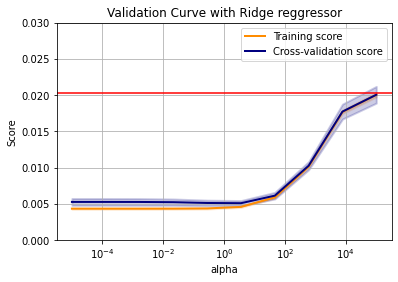

In [311]:
from sklearn.linear_model import Ridge
alpha_range = np.logspace(-5, 5, 10)
ridge_poly = Ridge(alpha=1.0, fit_intercept=True)

train_scores, test_scores  = sklearn.model_selection.validation_curve(ridge_poly,Xpoly,y,param_name='alpha',scoring='neg_mean_squared_error',param_range=alpha_range,cv = 5)
train_scores_mean = np.mean(np.abs(train_scores), axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(np.abs(test_scores), axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge reggressor")
plt.xlabel(r"$\k$")
plt.ylabel("Score")
plt.ylim(0, 0.03)
lw = 2
plt.semilogx(
    alpha_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    alpha_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    alpha_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    alpha_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
ymax = min(test_scores_mean)
index = np.argmin(test_scores_mean)
ymax2 = min(train_scores_mean)
index2 = np.argmin(train_scores_mean)
print(alpha_range[index],ymax)
print(index2,ymax2)
plt.axhline(y=test_mse, color='r', linestyle='-')

plt.grid()
plt.xlabel("alpha")
plt.legend(loc="best")
plt.show()

In [312]:
ridge_poly = Ridge(alpha=3.6, fit_intercept=True)
ridge_poly= ridge_poly.fit(Xpoly,y)

In [313]:
from sklearn.metrics import mean_squared_error
X_test = virus_labeled_test.drop(["VirusScore"],1)
y_test = virus_labeled_test['VirusScore']
y_hat_dummy = dummy_regr.predict(X_test)
dummy_test_mse = mean_squared_error(y_test, y_hat_dummy)
print(dummy_test_mse)

0.020367501736111116


In [314]:
from sklearn.metrics import mean_squared_error
y_hat_dummy = ridge.predict(X_test)
ridge_test_mse = mean_squared_error(y_test, y_hat_dummy)
print(ridge_test_mse)

0.009105444088794871


In [315]:
from sklearn.metrics import mean_squared_error
y_hat_dummy = lasso.predict(X_test)
lasso_test_mse = mean_squared_error(y_test, y_hat_dummy)
print(lasso_test_mse)

0.00877587786126076


In [316]:
from sklearn.metrics import mean_squared_error
poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = poly.fit_transform(X_test)
y_hat_dummy = ridge_poly.predict(X_test_poly)
ridge_poly_test_mse = mean_squared_error(y_test, y_hat_dummy)
print(ridge_poly_test_mse)

0.008013763477338776


Section 9

In [317]:

virus_labeled_data['blood_type_A'] = np.where(virus_labeled_data['blood_type'].str.contains('A'), 1, 0)
virus_unlabeled_data['blood_type_A'] = np.where(virus_unlabeled_data['blood_type'].str.contains('A'), 1, 0)
virus_labeled_data= virus_labeled_data.drop(["blood_type"],1)
virus_unlabeled_data= virus_unlabeled_data.drop(["blood_type"],1)
X = virus_labeled_data.drop(["VirusScore"],1)
y = virus_labeled_data['VirusScore']


In [320]:

ridge = ridge.fit(X,y)
y_pred_ridge = ridge.predict(virus_unlabeled_data)
import csv
with open('pred_4.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(pid,y_pred_ridge ))
df = pd.read_csv("pred_4.csv", header=None)
df.to_csv("pred_4.csv", header=["patient_id", "VirusScore"], index=False)

In [322]:
lasso = lasso.fit(X,y)
y_pred_lasso = lasso.predict(virus_unlabeled_data)
import csv
with open('pred_5.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(pid,y_pred_lasso ))
df = pd.read_csv("pred_5.csv", header=None)
df.to_csv("pred_5.csv", header=["patient_id", "VirusScore"], index=False)

In [323]:
ridge_poly = ridge_poly.fit(X,y)
y_pred_ridge_poly = ridge_poly.predict(virus_unlabeled_data)
import csv
with open('pred_6.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(pid,y_pred_ridge_poly ))
df = pd.read_csv("pred_6.csv", header=None)
df.to_csv("pred_6.csv", header=["patient_id", "VirusScore"], index=False)